In [24]:
import warnings
warnings.filterwarnings('ignore')

# Dependencies
import gym
import random 
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from mish import Mish
import matplotlib.pyplot as plt

In [25]:
# Creating the cartpole environment 
env = gym.make('CartPole-v1')

In [26]:
# We extract the action space and state space from the environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### We set hyperparameters and bunch of useful global variables

In [27]:
# We need to tweak these parameters as we don't really know how they affect the performance of the dqn network
gamma = 0.99
epsilon_decay = 0.995
epsilon_min = 0.001
batch_size = 64
train_start = 1000
memory_size = 10000
n_episodes = 400
n_win_ticks = 195 # This value determine if the game is solved or not (score > n_win_ticks over 100 episodes)
n_avg_scores = 100 # This value determine when the average score should be calculated (here every 100 episodes)
render = True

### Building the model architecture

In [28]:
def build_model():
    model = Sequential()
    model.add(Dense(128, input_dim = state_size))
    model.add(Mish())
    model.add(Dense(64))
    model.add(Mish())
    model.add(Dense(32))
    model.add(Mish())
    model.add(Dense(16))
    model.add(Mish())
    model.add(Dense(action_size))
    
    model.compile(Adam(lr = 0.001), loss = 'mse')
    return model

# Model summmary gives us a linear representation of our network
model = build_model()
target_model = build_model()

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 128)               640       
_________________________________________________________________
mish_23 (Mish)               (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
mish_24 (Mish)               (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
mish_25 (Mish)               (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 16)               

In [29]:
# Training helpers
# Source: https://github.com/yanpanlau/CartPole/blob/master/DQN/CartPole_DQN.py
def update_target_model():
    target_model.set_weights(model.get_weights())

def get_action(state, epsilon):
    return np.random.randint(action_size) if np.random.rand() <= epsilon else np.argmax(model.predict(state)[0])

def train_replay():
    if len(memory) < train_start:
        return
    minibatch = random.sample(memory,  min(batch_size, len(memory)))
    state_t, action_t, reward_t, state_t1, terminal = zip(*minibatch)
    state_t = np.concatenate(state_t)
    state_t1 = np.concatenate(state_t1)
    targets = model.predict(state_t)
    Q_sa = target_model.predict(state_t1)
    targets[range(batch_size), action_t] = reward_t + gamma * np.max(Q_sa, axis=1) * np.invert(terminal)
    model.train_on_batch(state_t, targets)

[Episode 0] Average Score: 29.0
[Episode 100] Average Score: 126.35
Solved after 7 tries! \o/
[Episode 200] Average Score: 304.94
[Episode 300] Average Score: 392.93


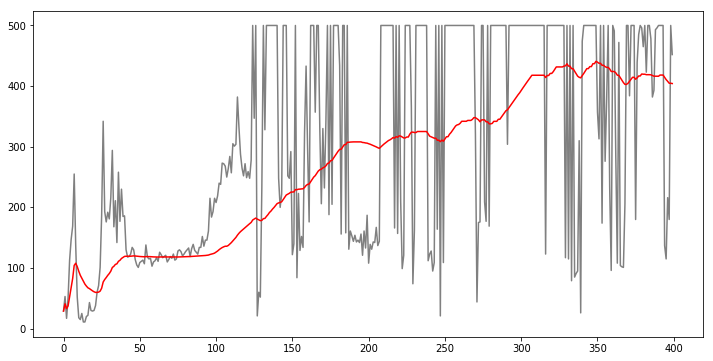

In [30]:
# Training
avg_scores = []
all_scores = []
scores = deque(maxlen=n_avg_scores)
memory = deque(maxlen=memory_size)

def learn():
    epsilon = 1.0 # Start with randomness
    has_won = False

    for e in range(n_episodes):
        # reset environmenent after each episode
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            action = get_action(state, epsilon)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            memory.append((state, action, reward if not done else -100, next_state, done)) # give a penalty of 100 if the action taken makes the episode end
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay # Decrease randomness
            train_replay()
            score += reward
            state = next_state
            
            # We render each 50 episodes
            if render and e % 50 == 0:
                env.render()

            if done:
                env.reset()
                update_target_model()
                scores.append(score)
                all_scores.append(score)
                avg_score = np.mean(scores)
                avg_scores.append(avg_score)

                if not has_won and e >= n_avg_scores and avg_score >= n_win_ticks:
                    # Find first score greater than 195 where the average is >= 195 over the following 100 episodes.
                    solution_episode_idx = max(next(x[0] for x in enumerate(all_scores) if x[1] >= n_win_ticks), e - n_win_ticks) 
                    print('Solved after {} tries! \o/'.format(solution_episode_idx))
                    has_won = True

                if e % n_avg_scores == 0:
                    print('[Episode {}] Average Score: {}'.format(e, avg_score))

learn()

# Plot results
plt.figure(figsize=(12,6))
plt.plot(all_scores, color='grey')
plt.plot(avg_scores, color='red')
plt.show()

